# Simulator of Siemens Biograph mMR PET-MR scanner

#### This notebook shows how to simulate PET acquisition and reconstruction using the Siemens Biograph mMR geometry  

# SIMULATION

In [1]:
import sys
import os
import tomolab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.io as io

In [2]:
sim_path = '/home/occiput/data/MartinosCenter/realdata/01'

## Set scanner geometry and characteristics

In [3]:
pet = tomolab.Reconstruction.PET_Static_Scan()
pet.set_scanner('Biograph_mMR') 

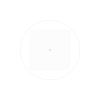

In [4]:
pet.binning

In [5]:
pet.use_compression(False) 

In [6]:
pet.import_sensitivity('%s/norm3d_00.h33'%sim_path) 

Ignore this message if this is a simulation. 
See the source code for more info. 


## Load activity phantom and attenuation phantom

#### Change the files here to change groundtruth activity and attenuation. Or change the variable simulation_path; in this case the new path must contains the required nifti files with the activity and attenuation phantoms. 

In [7]:
true_activity = tomolab.DataSources.load_nifti('%s/true_activity.nii'%sim_path)
attenuation   = tomolab.DataSources.load_nifti('%s/attenuation.nii'%sim_path)

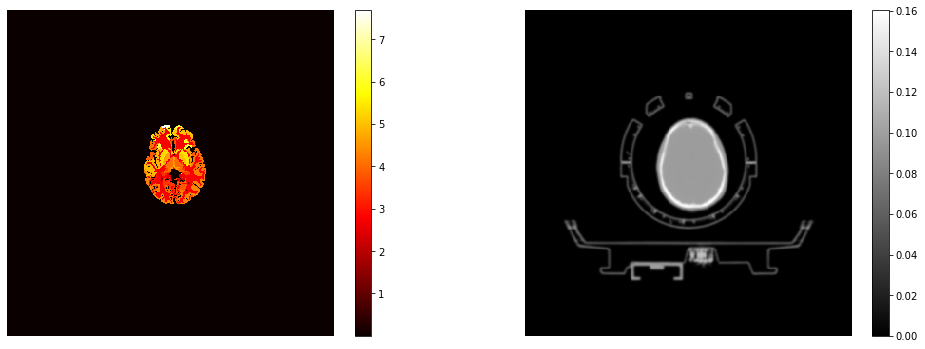

In [8]:
plt.figure(figsize=[17,6])
plt.subplot(1,2,1); plt.imshow(np.flipud(true_activity.data[:,:,64]),cmap='hot'), plt.axis('off'), plt.colorbar()
plt.subplot(1,2,2); plt.imshow(np.flipud(attenuation.data[:,:,64]),cmap='gray'), plt.axis('off'), plt.colorbar()
plt.show()

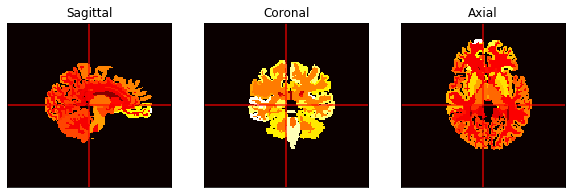

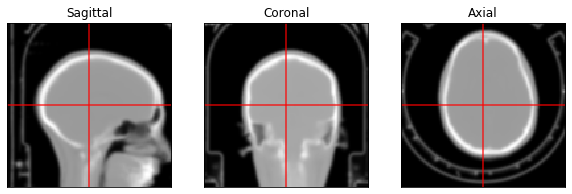

In [9]:
true_activity.display(cmap='hot', crop=125, figsize=(10,5))
attenuation.display(cmap='gray', crop=125, figsize=(10,5))

## Simulate PET acquisition

#### 1- Compute noiseless prompts in the ideal case (no scatter, no randoms)

In [10]:
# Set the discretization grid for the attenuation:
pet.set_attenuation_shape(attenuation.shape)
pet.set_attenuation_size([2.08626*pet.attenuation_shape[0], 2.08626*pet.attenuation_shape[1], 2.03125*pet.attenuation_shape[2]])
attenuation_projection = pet.project_attenuation(attenuation)

# Set the discretization grid for the activity: 
pet.set_activity_shape(true_activity.shape)
pet.set_activity_size([2.08626*pet.activity_shape[0], 2.08626*pet.activity_shape[1], 2.03125*pet.activity_shape[2]])
ideal_prompts = pet.project_activity(true_activity) 

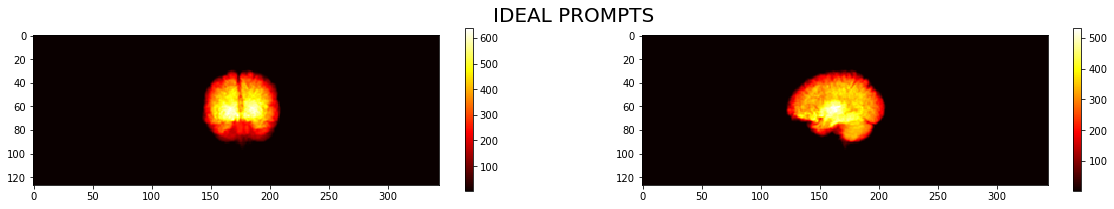

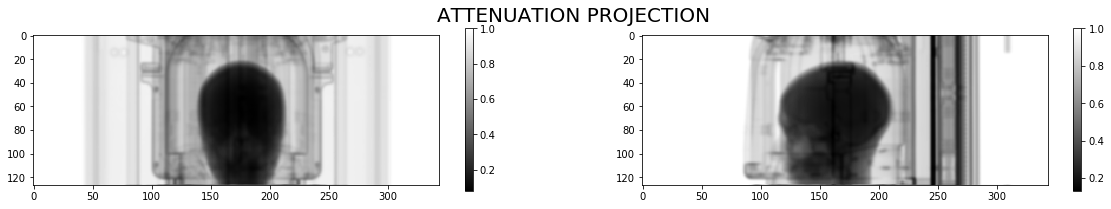

In [11]:
plt.figure(figsize=[20,3])
plt.subplot(1,2,1); plt.imshow(np.flipud(ideal_prompts.to_nd_array()[0,5,:,:].T), cmap="hot"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(np.flipud(ideal_prompts.to_nd_array()[126,5,:,:].T), cmap="hot"); plt.colorbar()
plt.suptitle('IDEAL PROMPTS', fontsize=20)
plt.show()

plt.figure(figsize=[20,3])
plt.subplot(1,2,1); plt.imshow(np.flipud(attenuation_projection.to_nd_array()[0,5,:,:].T), cmap="gray"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(np.flipud(attenuation_projection.to_nd_array()[126,5,:,:].T), cmap="gray"); plt.colorbar()
plt.suptitle('ATTENUATION PROJECTION', fontsize=20)
plt.show()

#### 2- Add expected randoms and scatter 

In [12]:
randoms = tomolab.DataSources.import_h5f_projection('%s/randoms.h5'%sim_path)
scatter = tomolab.DataSources.import_h5f_projection('%s/scatter.h5'%sim_path)

# NOTE: the randoms and scatter stored in the .h5 files above have been generated with an old version of occiput. The
# line below make them compatible. 
randoms.sparsity = ideal_prompts.sparsity
scatter.sparsity = ideal_prompts.sparsity

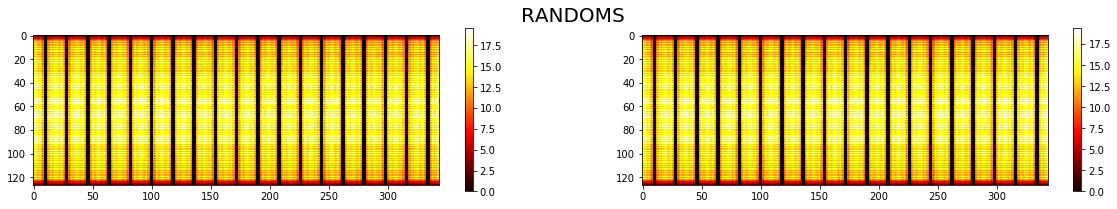

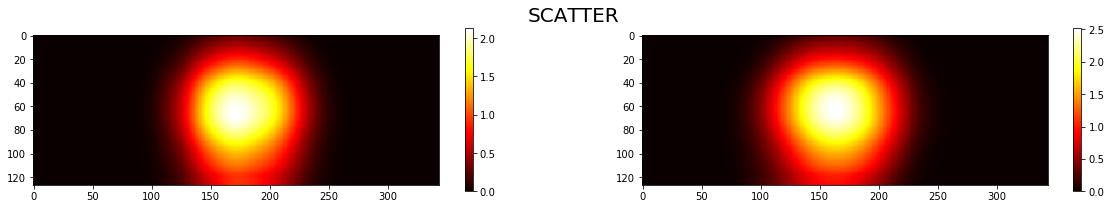

In [13]:
plt.figure(figsize=[20,3])
plt.subplot(1,2,1); plt.imshow(np.flipud(randoms.to_nd_array()[0,5,:,:].T), cmap="hot"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(np.flipud(randoms.to_nd_array()[126,5,:,:].T), cmap="hot"); plt.colorbar()
plt.suptitle('RANDOMS', fontsize=20)
plt.show()

plt.figure(figsize=[20,3])
plt.subplot(1,2,1); plt.imshow(np.flipud(scatter.to_nd_array()[0,5,:,:].T), cmap="hot"); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(np.flipud(scatter.to_nd_array()[126,5,:,:].T), cmap="hot"); plt.colorbar()
plt.suptitle('SCATTER', fontsize=20)
plt.show()

#### 3- Set scan duration and apply Poisson noise

In [14]:
acquisition_time_sec = 20*60 #seconds
counts_per_sec       = 500e3 #kCounts per second
total_counts         = acquisition_time_sec * counts_per_sec

scale = total_counts / ideal_prompts.get_integral()

randoms.data = randoms.data * scale
scatter.data = 10*scatter.data * scale 

prompts = ideal_prompts.copy()
prompts.data = ideal_prompts.data * scale * attenuation_projection.data * pet.sensitivity.data \
            + randoms.data + scatter.data * pet.sensitivity.data

noisy_prompts = prompts.copy()
noisy_prompts.apply_noise_Poisson()

print(true_activity.data.max(), true_activity.data.mean())
print(scale)
print(pet.scale_activity)

7.6961746 0.035592426
0.19592579672519905
3.4320000000000003e-05


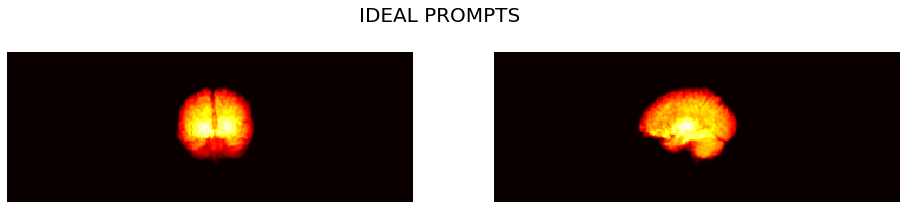

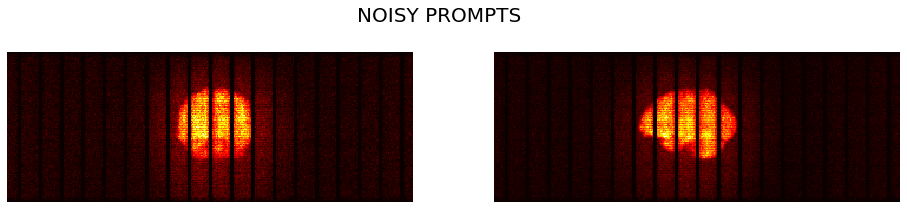

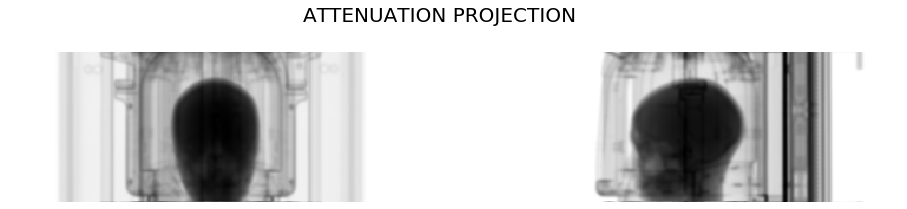

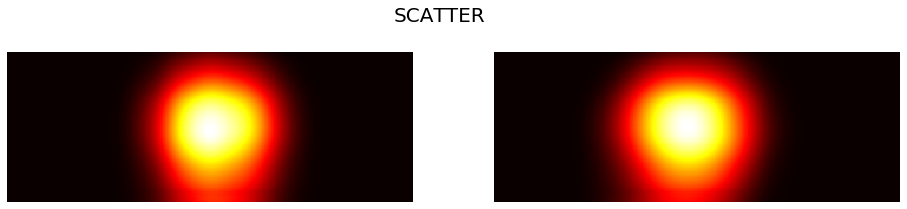

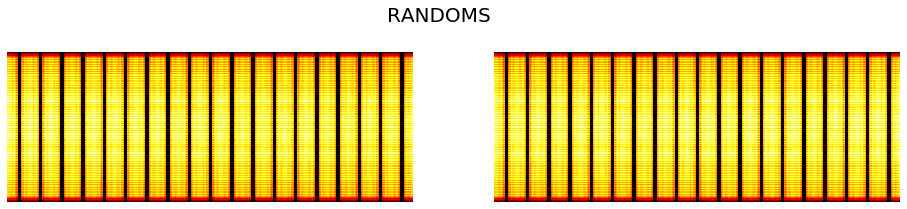

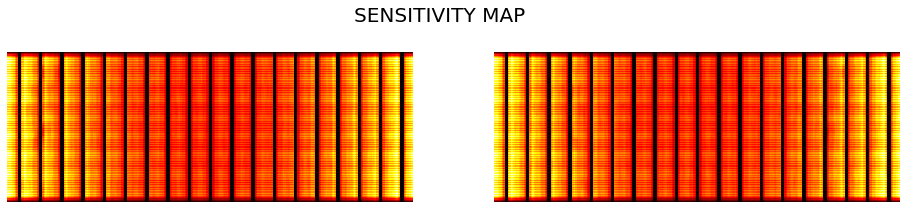

(Text(0.5, 0.98, 'SENSITIVITY MAP'), None)

In [15]:
plt.figure(figsize=[16,3.5])
plt.subplot(1,2,1); plt.imshow(np.flipud(ideal_prompts.to_nd_array()[0,5,:,:].T), cmap="hot"),plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.flipud(ideal_prompts.to_nd_array()[126,5,:,:].T), cmap="hot"),plt.axis('off')
plt.suptitle("IDEAL PROMPTS", fontsize=20), plt.show()
plt.figure(figsize=[16,3.5])
plt.subplot(1,2,1); plt.imshow(np.flipud(noisy_prompts.to_nd_array()[0,5,:,:].T), cmap="hot"),plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.flipud(noisy_prompts.to_nd_array()[126,5,:,:].T), cmap="hot"),plt.axis('off')
plt.suptitle("NOISY PROMPTS", fontsize=20), plt.show()
plt.figure(figsize=[16,3.5])
plt.subplot(1,2,1); plt.imshow(np.flipud(attenuation_projection.to_nd_array()[0,5,:,:].T), cmap="gray"),plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.flipud(attenuation_projection.to_nd_array()[126,5,:,:].T), cmap="gray"),plt.axis('off')
plt.suptitle("ATTENUATION PROJECTION", fontsize=20), plt.show()
plt.figure(figsize=[16,3.5])
plt.subplot(1,2,1); plt.imshow(np.flipud(scatter.to_nd_array()[0,5,:,:].T), cmap="hot"),plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.flipud(scatter.to_nd_array()[126,5,:,:].T), cmap="hot"),plt.axis('off')
plt.suptitle("SCATTER", fontsize=20), plt.show()
plt.figure(figsize=[16,3.5])
plt.subplot(1,2,1); plt.imshow(np.flipud(randoms.to_nd_array()[0,5,:,:].T), cmap="hot"),plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.flipud(randoms.to_nd_array()[126,5,:,:].T), cmap="hot"),plt.axis('off')
plt.suptitle("RANDOMS", fontsize=20), plt.show()
plt.figure(figsize=[16,3.5])
plt.subplot(1,2,1); plt.imshow(np.flipud(pet.sensitivity.to_nd_array()[0,5,:,:].T), cmap="hot"),plt.axis('off')
plt.subplot(1,2,2); plt.imshow(np.flipud(pet.sensitivity.to_nd_array()[126,5,:,:].T), cmap="hot"),plt.axis('off')
plt.suptitle("SENSITIVITY MAP", fontsize=20), plt.show()

## Reconstruct

In [16]:
#pet.set_prompts(ideal_prompts) 
pet.set_prompts(noisy_prompts) 
pet.set_randoms(randoms) 
pet.set_scatter(scatter) 
pet.set_attenuation_projection(attenuation_projection)
pet.set_activity_scale(1.0)  # set this to 1.0 when reconstructing simulated data

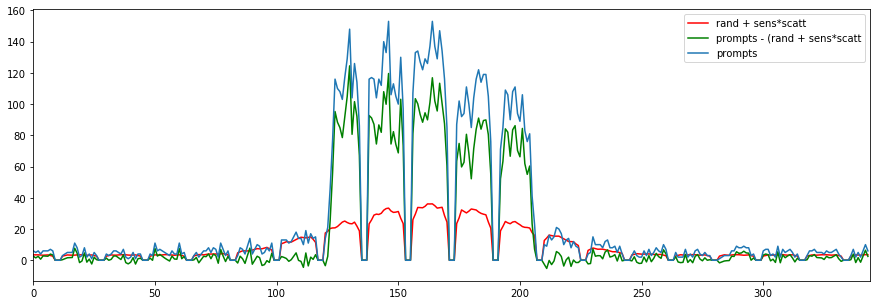

In [17]:
pet.quick_inspect()

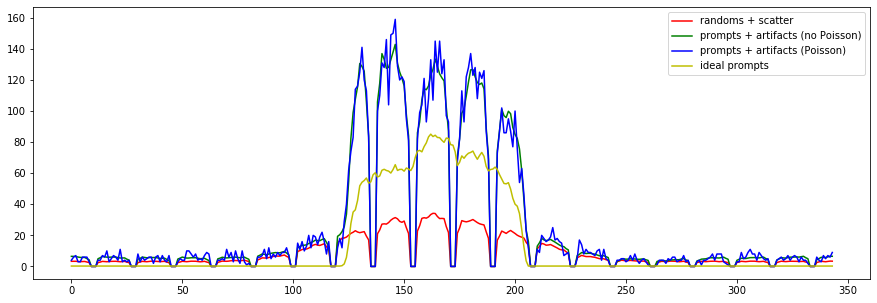

In [18]:
plt.figure(figsize=[15,5]); 
plt.plot(pet.randoms.data[126,8,:,70] + pet.scatter.data[126,8,:,70]*pet.sensitivity.data[126,5,:,70],'r',label = 'randoms + scatter'); 
plt.plot(prompts.data[126,8,:,70],'g',label = 'prompts + artifacts (no Poisson)');
plt.plot(pet.prompts.data[126,8,:,70],'b',label = 'prompts + artifacts (Poisson)');
plt.plot(ideal_prompts.data[126,8,:,70]*scale,'y',label = 'ideal prompts');
plt.legend()

#### 1- Set the option for reconstruction FOV

In [19]:
Nx = 344
Ny = 344
Nz = 127
pet.set_activity_shape([Nx,Ny,Nz])
pet.set_activity_size([2.08626*Nx, 2.08626*Ny, 2.03125*Nz])

In [20]:
activity = pet.osem_reconstruction(iterations=4, #tot_iter = n_subs x n_iter
                                   subset_mode="ordered_axial", 
                                   subset_number = 21,
                                   #attenuation_projection=attenuation_projection,
                                   #subset_size=12,
                                  )

subset number: 21
subset size: 12
iterations tot: 84


FloatProgress(value=0.0, bar_style='info', description='OSEM Reconstruction', layout=Layout(border='solid 1px'…

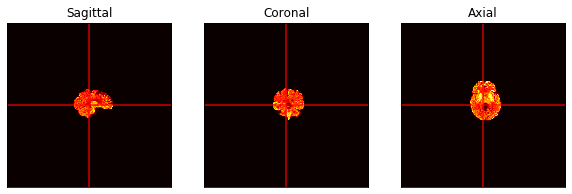

In [21]:
activity.display(cmap='hot', figsize=(10,5), clim=(0,1.3))

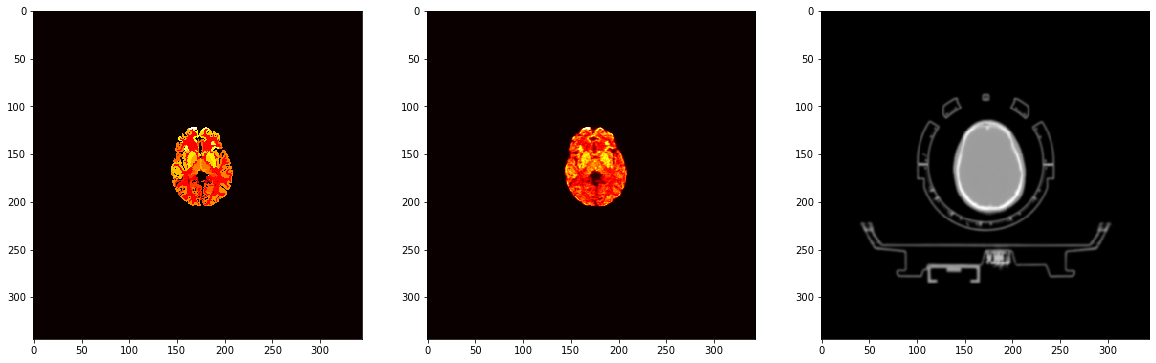

In [22]:
plt.figure(figsize=[20,10]) 
#plt.subplot(1,3,1); plt.imshow(np.flipud(true_activity.data[100:244,100:244,64]),cmap='hot',vmax=7.5,interpolation='nearest') 
plt.subplot(1,3,1); plt.imshow(np.flipud(true_activity.data[:,:,64]),cmap='hot',vmax=7.5,interpolation='nearest')
plt.subplot(1,3,2); plt.imshow(np.flipud(activity.data[:,:,64])*pet.scale_activity/scale,cmap='hot',vmax=7.5,interpolation='nearest') 
plt.subplot(1,3,3); plt.imshow(np.flipud(attenuation.data[:,:,64]),cmap='gray') 

7.6961746 0.035592426
10.537469372582702 0.03574515351157069


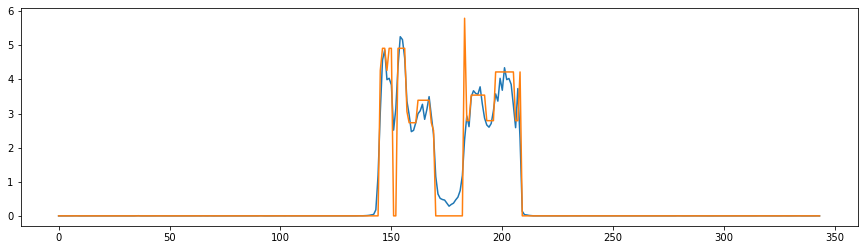

In [23]:
plt.figure(figsize=[15,4])
plt.plot(activity.data[170,:,64]*pet.scale_activity/scale)
plt.plot(true_activity.data[170,:,64])

print(true_activity.data.max(), true_activity.data.mean())
print(activity.data.max()*pet.scale_activity/scale, activity.data.mean()*pet.scale_activity/scale)

In [24]:
'''pet.prompts.save_to_file('%s/noisy_prompts.h5'%sim_path) 
activity.save_to_file('%s/activity_recon.nii'%sim_path) '''

"pet.prompts.save_to_file('%s/noisy_prompts.h5'%sim_path) \nactivity.save_to_file('%s/activity_recon.nii'%sim_path) "

#### 2- Set a custom (smaller) reconstruction FOV and increase (reconstruction) resolution

In [25]:
recon_shape = [250,250,250]
recon_size  = [250.0,250.0,250.0]#pet.resolution * recon_shape
pet.set_activity_shape(recon_shape)
pet.set_activity_size(recon_size)
print(pet.resolution)

[1. 1. 1.]


In [26]:
activity_zoom = pet.osem_reconstruction(iterations=5, #tot_iter = n_subs x n_iter
                                   subset_mode="ordered_axial", 
                                   subset_number = 21,
                                   #attenuation_projection=attenuation_projection,
                                   #subset_size=12,
                                  )

subset number: 21
subset size: 12
iterations tot: 105


FloatProgress(value=0.0, bar_style='info', description='OSEM Reconstruction', layout=Layout(border='solid 1px'…

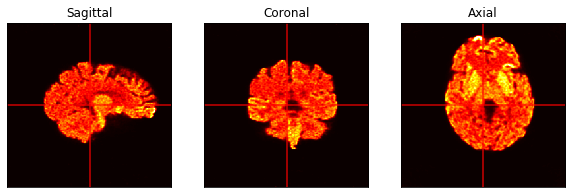

In [31]:
activity_zoom.display(cmap='hot',
                      figsize=(10,5), 
                      clim=(0,1.4) ,
                      res=pet.resolution)

In [32]:
activity_zoom.volume_render(res=pet.resolution, autotranspose=True)